In [1]:
import matplotlib.pyplot as plt

/opt/anaconda3/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


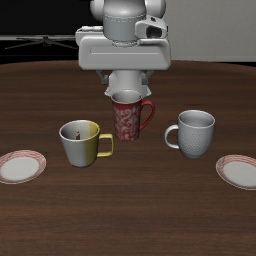

In [2]:
import pandas as pd
from io import BytesIO
from PIL import Image, ImageFile
import torch
import numpy as np
import requests

from transformers import AutoImageProcessor, MobileViTForSemanticSegmentation

# Load a parquet file
df = pd.read_parquet("~/.cache/huggingface/lerobot/libero/data/chunk-000/file-000.parquet")
image = Image.open(BytesIO(df['observation.images.image'][0]['bytes']))
display(image)

In [3]:
df_tasks = pd.read_parquet("~/.cache/huggingface/lerobot/libero/meta/tasks.parquet")
df_tasks.columns

Index(['task_index'], dtype='object')

In [4]:
df_tasks

task_index
put the white mug on the left plate and put the...           0
put the white mug on the plate and put the choc...           1
put the yellow and white mug in the microwave a...           2
turn on the stove and put the moka pot on it                 3
put both the alphabet soup and the cream cheese...           4
put both the alphabet soup and the tomato sauce...           5
put both moka pots on the stove                              6
put both the cream cheese box and the butter in...           7
put the black bowl in the bottom drawer of the ...           8
pick up the book and place it in the back compa...           9
put the bowl on the plate                                   10
put the wine bottle on the rack                             11
open the top drawer and put the bowl inside                 12
put the cream cheese in the bowl                            13
put the wine bottle on top of the cabinet                   14
push the plate to the front of the stove                    15
turn on the stove                                           16
put the bowl on the stove                                   17
put the bowl on top of the cabinet                          18
open the middle drawer of the cabinet                       19
pick up the orange juice and place it in the ba...          20
pick up the ketchup and place it in the basket              21
pick up the cream cheese and place it in the ba...          22
pick up the bbq sauce and place it in the basket            23
pick up the alphabet soup and place it in the b...          24
pick up the milk and place it in the basket                 25
pick up the salad dressing and place it in the ...          26
pick up the butter and place it in the basket               27
pick up the tomato sauce and place it in the ba...          28
pick up the chocolate pudding and place it in t...          29
pick up the black bowl next to the cookie box a...          30
pick up the black bowl in the top drawer of the...          31
pick up the black bowl on the ramekin and place...          32
pick up the black bowl on the stove and place i...          33
pick up the black bowl between the plate and th...          34
pick up the black bowl on the cookie box and pl...          35
pick up the black bowl next to the plate and pl...          36
pick up the black bowl next to the ramekin and ...          37
pick up the black bowl from table center and pl...          38
pick up the black bowl on the wooden cabinet an...          39

In [5]:
ckpt = "apple/deeplabv3-mobilevit-small"
processor = AutoImageProcessor.from_pretrained(ckpt)
model = MobileViTForSemanticSegmentation.from_pretrained(ckpt)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
def run_seg(model: MobileViTForSemanticSegmentation, image: ImageFile):
	inputs = processor(images=image, return_tensors="pt")
	with torch.no_grad():
		outputs = model(**inputs)

	# outputs.logits: [B, num_labels, h/stride, w/stride]
	# Upsample back to original image size
	upsampled = torch.nn.functional.interpolate(
		outputs.logits,
		size=image.size[::-1],            # (H, W)
		mode="bilinear",
		align_corners=False,
	)

	# Per-pixel class IDs
	pred_ids = upsampled.argmax(dim=1)[0].cpu().numpy()     # shape (H, W)

	# Map the IDs to string labels
	id2label = model.config.id2label                         # e.g., {0: 'background', 1: 'wall', ...}
	unique_ids = np.unique(pred_ids)
	present_labels = [id2label[int(i)] for i in unique_ids]

	print("Mask shape:", pred_ids.shape)                     # per-pixel segmentation mask
	print("Labels present:", present_labels)
	num_classes = len(model.config.id2label)
	colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
	seg_image = colors[pred_ids]

	alpha = 0.9
	overlay = Image.blend(
		image.convert("RGBA"),
		Image.fromarray(seg_image).convert("RGBA"),
		alpha=alpha
	)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.title("Original Image")
	plt.imshow(image)
	plt.axis("off")

	plt.subplot(1, 2, 2)
	plt.title("Segmentation Overlay")
	plt.imshow(overlay)
	plt.axis("off")

	plt.show()
	return pred_ids


Mask shape: (256, 256)
Labels present: ['background', 'tvmonitor']


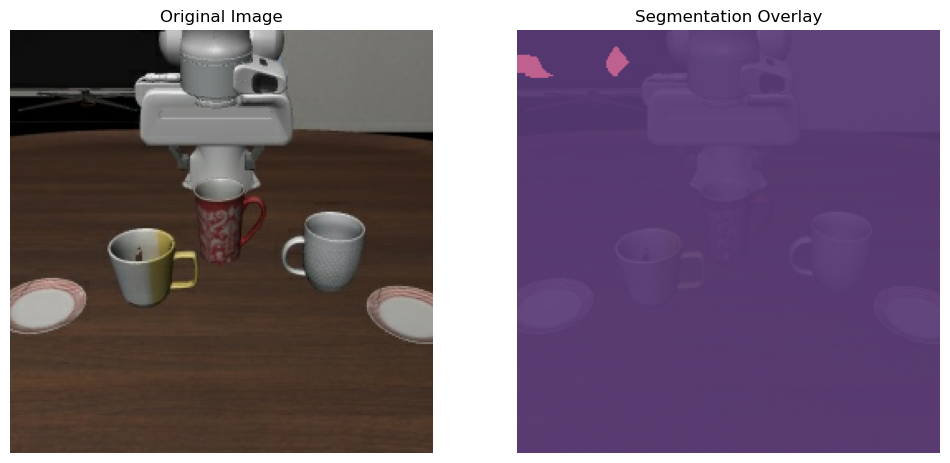

Mask shape: (256, 256)
Labels present: ['background']


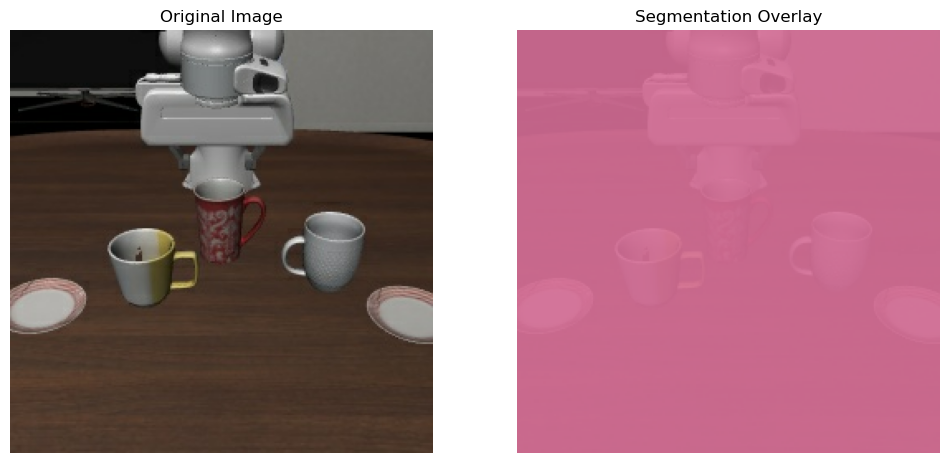

Mask shape: (256, 256)
Labels present: ['background', 'tvmonitor']


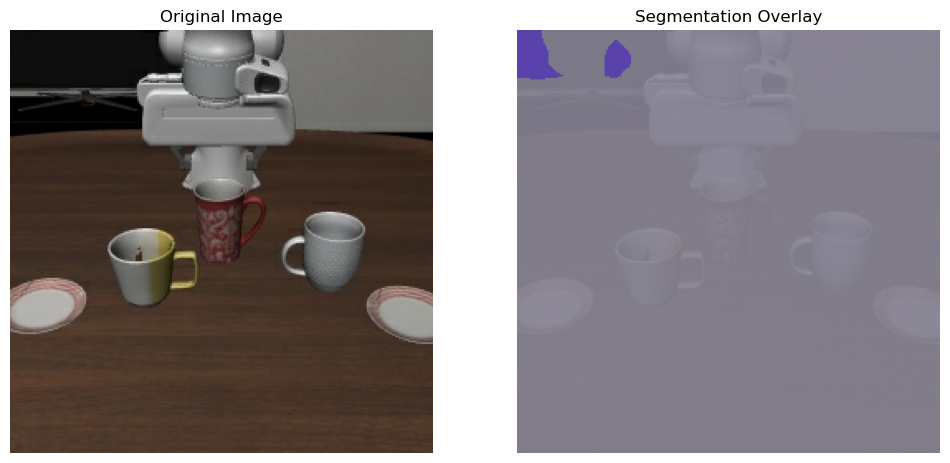

Mask shape: (256, 256)
Labels present: ['background']


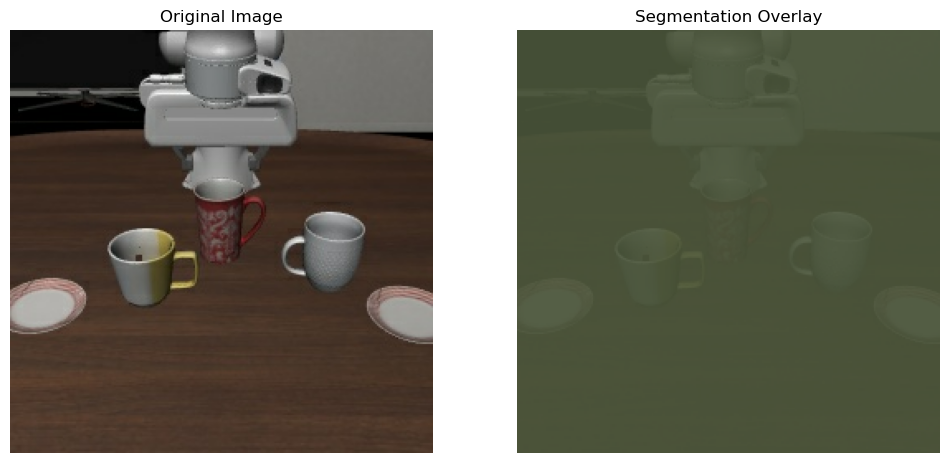

Mask shape: (256, 256)
Labels present: ['background']


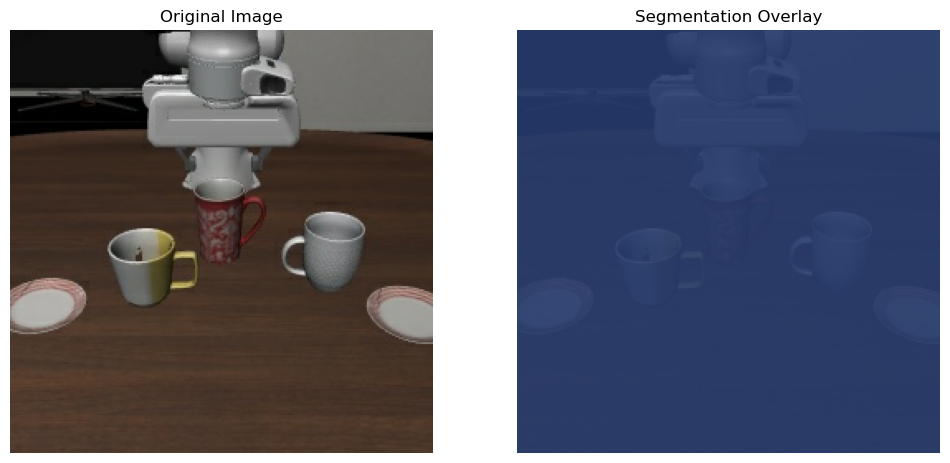

In [7]:
for i in range(5, 10):
	image = Image.open(BytesIO(df['observation.images.image'][i]['bytes']))
	run_seg(model, image)

/opt/anaconda3/envs/lerobot/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Labels present: ['animal', 'apparel', 'bag', 'base', 'bed ', 'blanket', 'book', 'bottle', 'ceiling', 'counter', 'cushion', 'floor', 'palm', 'person', 'seat', 'shelf', 'signboard', 'sky', 'towel', 'wall']


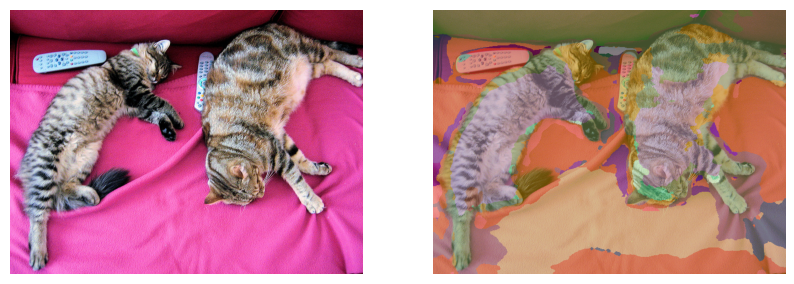

In [8]:
import torch, numpy as np
from PIL import Image
import requests, matplotlib.pyplot as plt
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

ckpt = "nvidia/segformer-b2-finetuned-ade-512-512"
processor = AutoImageProcessor.from_pretrained(ckpt)
model = SegformerForSemanticSegmentation.from_pretrained(ckpt).eval()

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    out = model(**inputs)

ups = torch.nn.functional.interpolate(
    out.logits, size=image.size[::-1], mode="bilinear", align_corners=False
)
pred = ups.argmax(1)[0].cpu().numpy()
id2label = model.config.id2label

# colored overlay
palette = np.random.randint(0,255,(len(id2label),3),dtype=np.uint8)
seg_rgb = palette[pred]
overlay = Image.blend(image.convert("RGBA"), Image.fromarray(seg_rgb).convert("RGBA"), alpha=0.55)

print("Labels present:", sorted({id2label[int(i)] for i in np.unique(pred)}))
plt.figure(figsize=(10,5)); plt.subplot(1,2,1); plt.imshow(image); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); plt.show()

Mask shape: (256, 256)
Labels present: ['wall', 'floor', 'table', 'chair', 'box', 'sink', 'book', 'bottle', 'plaything', 'stool', 'ball', 'ashcan', 'plate', 'glass']


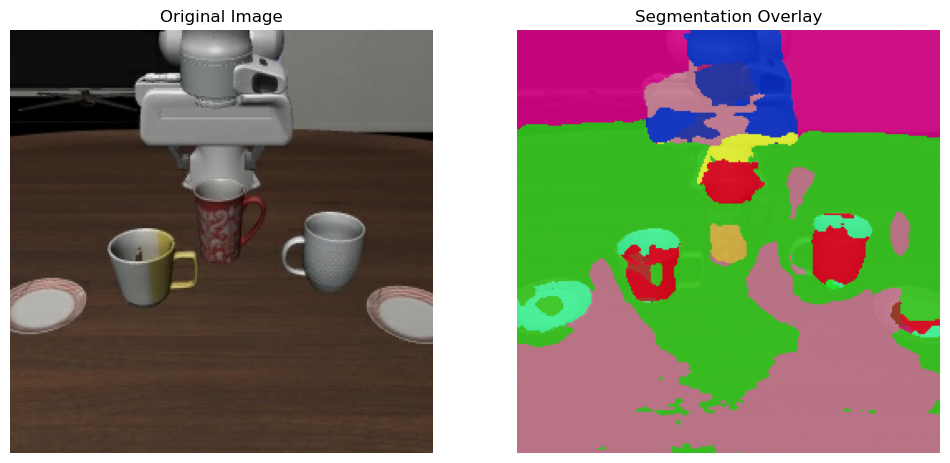

Mask shape: (256, 256)
Labels present: ['wall', 'floor', 'table', 'chair', 'box', 'sink', 'book', 'bottle', 'plaything', 'stool', 'ball', 'ashcan', 'plate', 'glass']


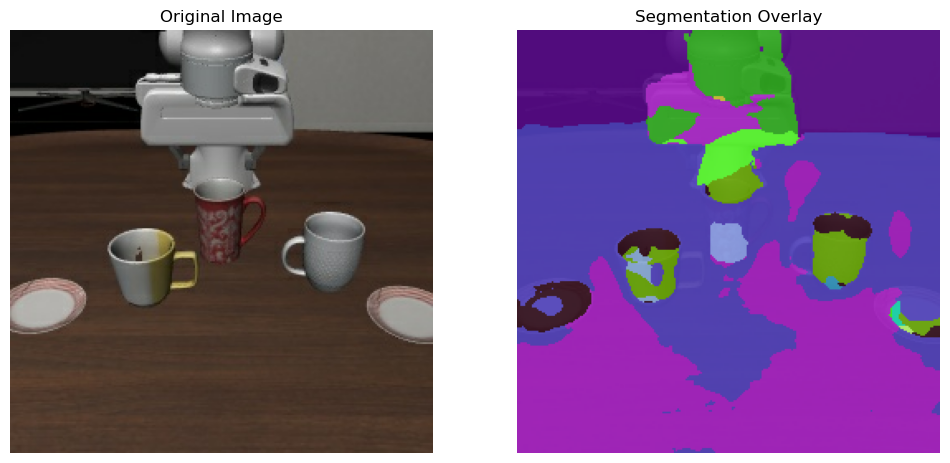

Mask shape: (256, 256)
Labels present: ['wall', 'floor', 'cabinet', 'table', 'chair', 'rug', 'desk', 'box', 'sink', 'book', 'bottle', 'plaything', 'stool', 'ball', 'ashcan', 'glass']


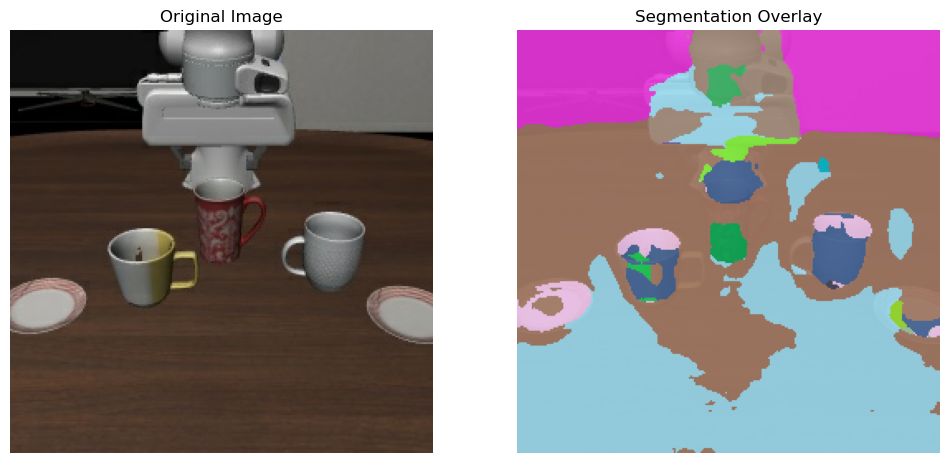

Mask shape: (256, 256)
Labels present: ['wall', 'floor', 'cabinet', 'table', 'chair', 'rug', 'box', 'sink', 'book', 'bottle', 'plaything', 'stool', 'ball', 'ashcan', 'plate', 'glass']


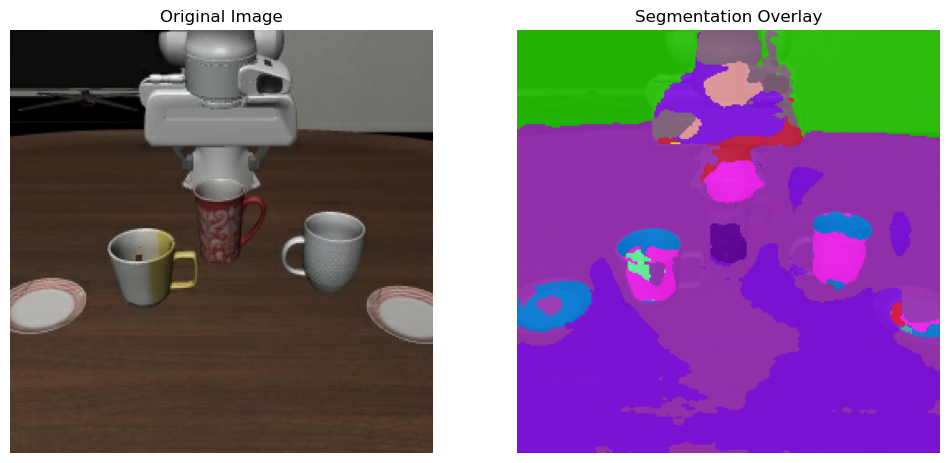

Mask shape: (256, 256)
Labels present: ['wall', 'floor', 'table', 'chair', 'rug', 'sink', 'book', 'bottle', 'plaything', 'stool', 'ball', 'ashcan', 'plate', 'glass']


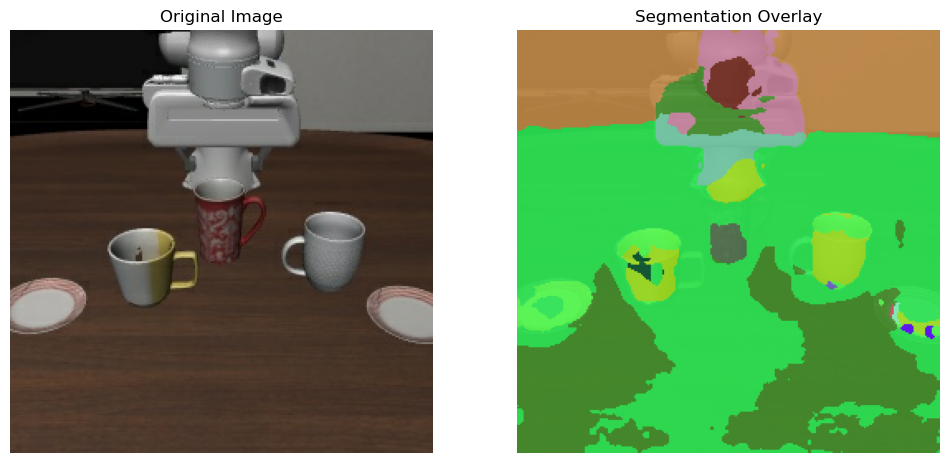

In [9]:
for i in range(5, 10):
	image = Image.open(BytesIO(df['observation.images.image'][i]['bytes']))
	run_seg(model, image)

/opt/anaconda3/envs/lerobot/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Labels present: ['bag', 'bottle', 'plaything']


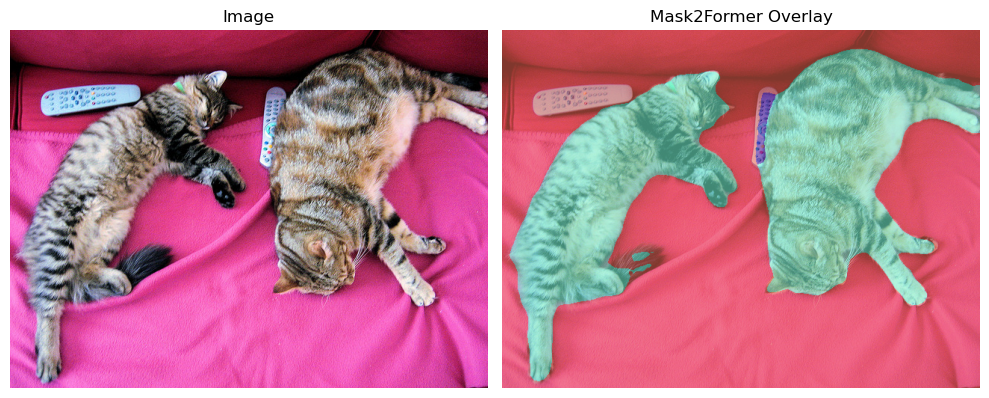

In [19]:
import torch, numpy as np
from PIL import Image
import requests, matplotlib.pyplot as plt
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# --- load image ---
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# --- model: Mask2Former (Swin-L) on ADE20K ---
ckpt = "facebook/mask2former-swin-small-ade-semantic"
processor = AutoImageProcessor.from_pretrained(ckpt)
model = Mask2FormerForUniversalSegmentation.from_pretrained(ckpt).eval()

# (optional) run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- inference ---
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    out = model(**inputs)

# post-process to original image size (H, W)
pred = processor.post_process_semantic_segmentation(
    out, target_sizes=[image.size[::-1]]
)[0].cpu().numpy()

id2label = model.config.id2label

# --- colored overlay ---
# palette sized to the max label present (saves memory and avoids indexing issues)
num_colors = int(pred.max()) + 1
palette = np.random.randint(0, 255, (num_colors, 3), dtype=np.uint8)
seg_rgb = palette[pred]  # (H, W, 3)

overlay = Image.blend(
    image.convert("RGBA"),
    Image.fromarray(seg_rgb).convert("RGBA"),
    alpha=0.55
)

# labels present
labels_present = sorted({id2label[int(i)] for i in np.unique(pred) if int(i) in id2label})
print("Labels present:", labels_present)

# --- visualize ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(image); plt.axis("off"); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); plt.title("Mask2Former Overlay")
plt.tight_layout(); plt.show()

In [20]:
import torch, numpy as np
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- core forward to per-pixel probs (works for Mask2Former + SegFormer) ---
def _forward_probs(model, processor, image_pil, device):
    if not isinstance(image_pil, Image.Image):
        image_pil = Image.fromarray(image_pil)
    image_pil = image_pil.convert("RGB")
    H, W = image_pil.size[1], image_pil.size[0]

    inputs = processor(images=image_pil, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)

    if hasattr(out, "class_queries_logits") and hasattr(out, "masks_queries_logits"):
        # Mask2Former-style
        class_probs = out.class_queries_logits.softmax(-1)[..., :-1]        # [B,Q,C]
        mask_probs  = out.masks_queries_logits.sigmoid()                    # [B,Q,h',w']
        mask_probs  = F.interpolate(mask_probs, size=(H, W), mode="bilinear", align_corners=False)
        scores = torch.einsum("bqc,bqhw->bchw", class_probs, mask_probs)    # [B,C,H,W]
        probs  = scores.softmax(dim=1)                                      # [B,C,H,W]
    else:
        # SegFormer-style
        up = F.interpolate(out.logits, size=(H, W), mode="bilinear", align_corners=False)  # [B,C,H,W]
        probs = up.softmax(dim=1)
    return probs[0]  # [C,H,W] on device

def _annotate(image_rgba, pred_np, probs_np, id2label, min_pixels=80, tiny_labels=("cup","mug"), tiny_min=10):
    img = image_rgba.copy()
    draw = ImageDraw.Draw(img)
    try: font = ImageFont.truetype("DejaVuSans.ttf", 16)
    except: font = ImageFont.load_default()

    # class confidences = mean prob over predicted pixels
    class_conf = {}
    for cid in np.unique(pred_np):
        mask = (pred_np == cid)
        if not mask.any(): continue
        conf = float(probs_np[cid][mask].mean())
        class_conf[int(cid)] = conf

    # id lookup for tiny objects (cup/mug)
    tiny_ids = {cid for cid, name in getattr(id2label, "items", lambda: [])() if str(name).lower() in tiny_labels}
    h, w = pred_np.shape
    for cid, conf in sorted(class_conf.items(), key=lambda x: -x[1]):
        if cid not in id2label: continue
        mask = (pred_np == cid)
        count = int(mask.sum())
        need = tiny_min if cid in tiny_ids else min_pixels
        if count < need: 
            continue

        ys, xs = np.where(mask)
        cx, cy = int(xs.mean()), int(ys.mean())
        label = f"{id2label[cid]}: {conf*100:.1f}%"
        tw, th = draw.textbbox((0,0), label, font=font)[2:]
        x0, y0 = max(0, cx - tw//2 - 6), max(0, cy - th//2 - 4)
        x1, y1 = min(w, x0 + tw + 12), min(h, y0 + th + 8)
        draw.rectangle([x0,y0,x1,y1], fill=(0,0,0,160))
        draw.text((x0+6, y0+4), label, fill=(255,255,255,255), font=font)
    return img, class_conf

def run_seg_with_labels_tta(model, processor, image, scales=(0.75, 1.0, 1.25, 1.5), hflip=True, alpha=0.55, show=True):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = image.convert("RGB")
    H, W = image.size[1], image.size[0]
    C = len(model.config.id2label)

    probs_acc = torch.zeros((C, H, W), device=device)
    samples = 0

    for s in scales:
        sized = image.resize((round(W*s), round(H*s)), Image.BICUBIC)
        p = _forward_probs(model, processor, sized, device)                           # [C,h,w]
        p = F.interpolate(p.unsqueeze(0), size=(H,W), mode="bilinear", align_corners=False)[0]
        probs_acc += p; samples += 1

        if hflip:
            flip = ImageOps.mirror(sized)
            pf = _forward_probs(model, processor, flip, device)
            pf = torch.flip(pf, dims=[-1])  # unflip
            pf = F.interpolate(pf.unsqueeze(0), size=(H,W), mode="bilinear", align_corners=False)[0]
            probs_acc += pf; samples += 1

    probs = (probs_acc / samples).clamp_min_(1e-7)   # [C,H,W]
    pred  = probs.argmax(dim=0).cpu().numpy()        # (H,W)
    probs_np = probs.detach().cpu().numpy()

    # color overlay
    palette = np.random.randint(0,255,(int(pred.max())+1,3),dtype=np.uint8)
    seg_rgb = palette[pred]
    overlay = Image.blend(image.convert("RGBA"), Image.fromarray(seg_rgb).convert("RGBA"), alpha=alpha)

    annotated, class_conf = _annotate(overlay, pred, probs_np, model.config.id2label)

    if show:
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1); plt.imshow(image); plt.axis("off"); plt.title("Image")
        plt.subplot(1,2,2); plt.imshow(annotated); plt.axis("off"); plt.title("TTA seg + labels")
        plt.tight_layout(); plt.show()

    return pred, annotated, class_conf

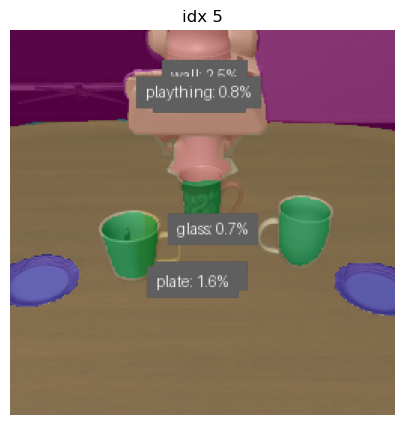

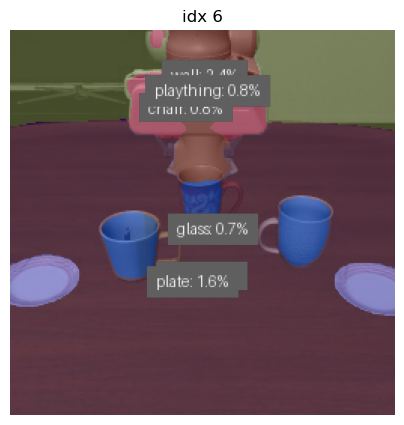

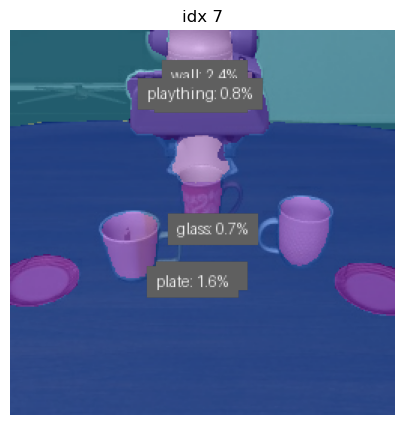

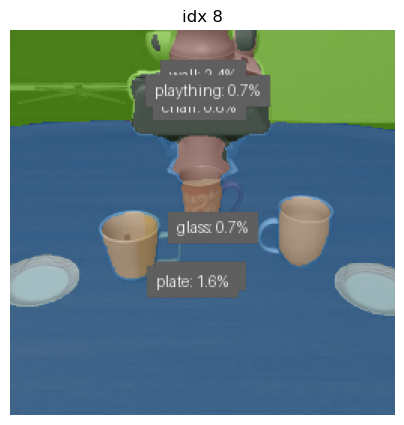

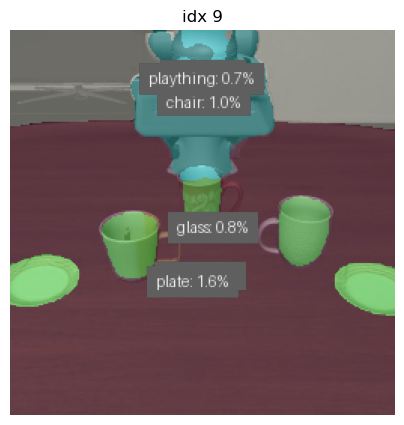

In [21]:
from io import BytesIO
for i in range(5, 10):
    img = Image.open(BytesIO(df['observation.images.image'][i]['bytes'])).convert("RGB")
    _, annotated, confs = run_seg_with_labels_tta(model, processor, img, show=False)
    plt.figure(figsize=(5,5)); plt.imshow(annotated); plt.axis("off"); plt.title(f"idx {i}"); plt.show()

In [25]:
# ---- get_pred_probs_overlay: returns pred, probs_np, overlay ----
import torch, numpy as np
import torch.nn.functional as F
from PIL import Image, ImageOps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def _forward_probs_single(model, processor, image_rgb, H, W):
    # one forward pass → per-pixel class probabilities [C,H,W] (on device)
    inputs = processor(images=image_rgb, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)

    if hasattr(out, "class_queries_logits") and hasattr(out, "masks_queries_logits"):  # Mask2Former
        class_probs = out.class_queries_logits.softmax(-1)[..., :-1]        # [B,Q,C]
        mask_probs  = out.masks_queries_logits.sigmoid()                    # [B,Q,h',w']
        mask_probs  = F.interpolate(mask_probs, size=(H, W), mode="bilinear", align_corners=False)
        scores = torch.einsum("bqc,bqhw->bchw", class_probs, mask_probs)    # [B,C,H,W]
        probs  = scores.softmax(dim=1)
    else:                                                                     # SegFormer-style
        up = F.interpolate(out.logits, size=(H, W), mode="bilinear", align_corners=False)
        probs = up.softmax(dim=1)
    return probs[0]  # [C,H,W] on device

def get_pred_probs_overlay(model, processor, image, scales=(0.75, 1.0, 1.25, 1.5), hflip=True, alpha=0.55):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = image.convert("RGB")
    H, W = image.size[1], image.size[0]
    C = len(model.config.id2label)

    probs_acc = torch.zeros((C, H, W), device=device)
    samples = 0

    for s in scales:
        sized = image.resize((round(W*s), round(H*s)), Image.BICUBIC)
        p = _forward_probs_single(model, processor, sized, H, W)
        probs_acc += p; samples += 1

        if hflip:
            flip = ImageOps.mirror(sized)
            pf = _forward_probs_single(model, processor, flip, H, W)
            pf = torch.flip(pf, dims=[-1])  # unflip horizontally
            probs_acc += pf; samples += 1

    probs = (probs_acc / samples).clamp_min_(1e-7)           # [C,H,W] (device)
    pred  = probs.argmax(dim=0).cpu().numpy()                # (H,W)
    probs_np = probs.detach().cpu().numpy()                  # (C,H,W)

    # make the color overlay for visualization
    palette = np.random.randint(0, 255, (int(pred.max()) + 1, 3), dtype=np.uint8)
    seg_rgb = palette[pred]
    overlay = Image.blend(image.convert("RGBA"), Image.fromarray(seg_rgb).convert("RGBA"), alpha=alpha)
    return pred, probs_np, overlay

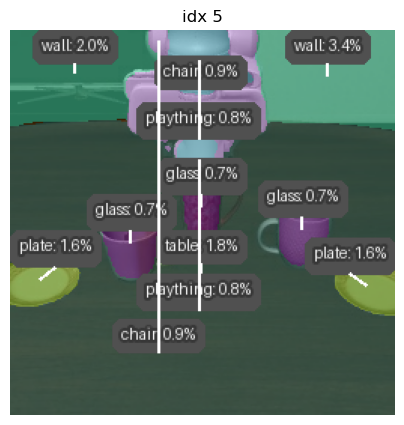

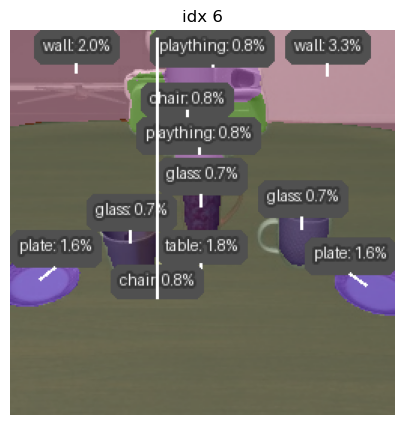

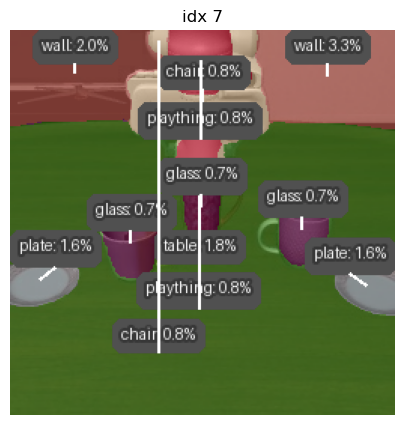

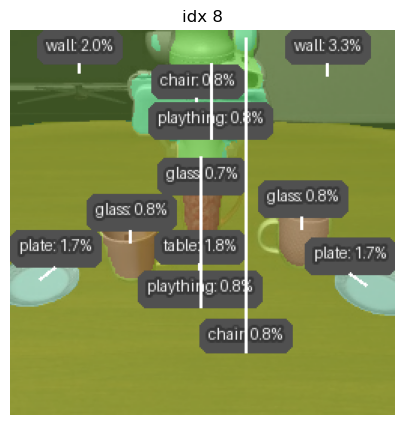

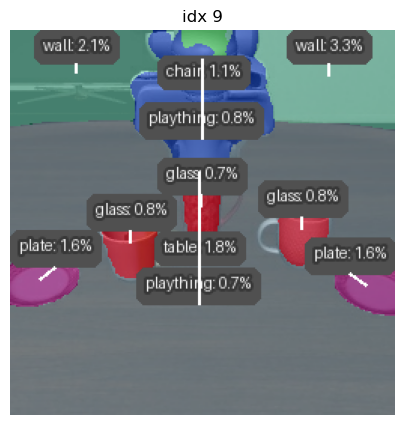

In [26]:
from io import BytesIO
for i in range(5, 10):
    img = Image.open(BytesIO(df['observation.images.image'][i]['bytes'])).convert("RGB")
    pred, probs_np, overlay = get_pred_probs_overlay(model, processor, img)  # <-- defines probs_np
    annotated = annotate_instances(
        overlay, pred, probs_np, model.config.id2label,
        min_pixels=60, tiny_labels=("cup","mug"), tiny_min=12, conf_stat="p90"
    )
    plt.figure(figsize=(5,5)); plt.imshow(annotated); plt.axis("off"); plt.title(f"idx {i}"); plt.show()